# Voxelmorph training Notebook

Largely inspired by [Voxelmorph's notebook tutorial](https://colab.research.google.com/drive/1WiqyF7dCdnNBIANEY80Pxw_mVz4fyV-S?usp=sharing#scrollTo=Fw6dKBjBPXNp).

In [2]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# suppress info and warn TF logs
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import time
import cv2
import tifffile as tiff
import numpy as np
import matplotlib
import voxelmorph as vxm
import tensorflow as tf
import nibabel as nib
import neurite as ne
from matplotlib import pyplot as plt
from IPython.display import Video

plt.rcParams["animation.html"] = "jshtml" 
plt.rcParams["animation.embed_limit"] = "500"  # size limit in MB

# Font size
plt.style.use('default')

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%reload_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

In [3]:
from stabilize2p.utils import make_video

def frame_gen(video, scores=None, lt=0.9):
    std = video[0].std()
    print('calculated std')
    low = np.quantile(video[0], q=0.01)
    if scores is not None:
        for img, score in zip(video, scores):
            img = (img - low) / std * 255 / 3
            img[img < 0] = 0
            img[img > 255] = 255
            img = img.astype(np.uint8)
            if score < lt:
                img[:50, :50] = 255
            else:
                img[:50, :50] = 0
            yield img
    else:
        for img in video:
            img = (img - low) / std * 255 / 3
            img[img < 0] = 0
            img[img > 255] = 255
            img = img.astype(np.uint8)
            yield img

In [4]:
orig_examples = [
    '../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.tif'
]

ofco_examples = [
    '../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/warped_red.tif'
]

pystackreg_examples = [
    '../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.pystackreg-affine.tif'
]

RANDOM_SEED = 1

In [ ]:
from stabilize2p.utils import vxm_data_generator

## Fully-Conv NN

In [5]:
from stabilize2p.utils import get_strategy
strategy = get_strategy('GPU')

[2021-12-02 10:43:05,226] I T140288727421312 utils.py:715: Num Physical GPUs Available: 0
[2021-12-02 10:43:05,228] I T140288727421312 utils.py:716: Num Logical  GPUs Available: 0
[2021-12-02 10:43:05,229] I T140288727421312 utils.py:717: Num TPUs Available: 0
[2021-12-02 10:43:05,229] I T140288727421312 utils.py:747: using default strategy.


In [8]:
# retrieve dataset shape
PATH = orig_examples[0]
in_shape = tiff.imread(PATH, key=0).shape

In [16]:
# configure unet features 
nb_features = [
    [16, 32, 32, 128, 128],         # encoder features
    [128, 128, 32, 32, 32, 16, 16]  # decoder features
]

# build model using VxmDense
with strategy.scope():
    vxm_model = vxm.networks.VxmDense(in_shape, nb_features, int_steps=0)

In [17]:
vxm_model.summary(line_length = 180)

Model: "vxm_dense"
____________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                              Output Shape                            Param #              Connected to                                                
 vxm_dense_source_input (InputLayer)                       [(None, 480, 736, 1)]                   0                    []                                                          
                                                                                                                                                                                    
 vxm_dense_target_input (InputLayer)                       [(None, 480, 736, 1)]                   0                    []                                                          
                                                                            

In [15]:
print('input shape: ', ', '.join([str(t.shape) for t in vxm_model.inputs]))
print('output shape:', ', '.join([str(t.shape) for t in vxm_model.outputs]))

input shape:  (None, 480, 736, 1), (None, 480, 736, 1)
output shape: (None, 480, 736, 1), (None, 480, 736, 2)


## Loss

In [37]:
# voxelmorph has a variety of custom loss classes
losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]

# usually, we have to balance the two losses by a hyper-parameter
lambda_param = 0.05
loss_weights = [1, lambda_param]

In [38]:
# (batch_size, *vol_shape, nb_feats)
shape = (1, 10, 10, 1)
vxm.losses.NCC().loss(tf.ones(shape), tf.zeros(shape)).numpy()

array([-0.04000058], dtype=float32)

## Compile model

In [49]:
with strategy.scope():
    vxm_model.compile(optimizer='Adam', loss=losses, loss_weights=loss_weights)

## Train

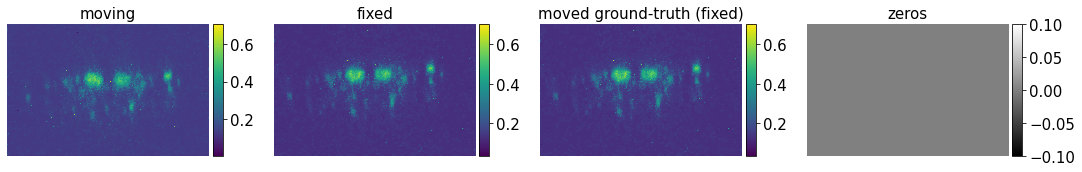

x_val.min()=0.012608264885422993 | x_val.max()=0.9202754961807664


In [54]:
batch_size = 16


x_train = tiff.imread(orig_examples[0], key=range(200))
x_train, (x_train_low, x_train_hig) = preprocessing(x_train)

# let's test it
np.random.seed(RANDOM_SEED)
train_generator = vxm_data_generator(x_train, batch_size=batch_size)
in_sample, out_sample = next(train_generator)

# visualize
images = [img[0, :, :, 0] for img in in_sample + out_sample] 
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['viridis', 'viridis', 'viridis', 'gray'], do_colorbars=True);

# validation
x_val = tiff.imread(orig_examples[1], key=range(200))
x_val = (x_val - x_train_low) / (x_train_hig - x_train_low)
print(f'{x_val.min()=} | {x_val.max()=}')

# let's get some data
val_generator = vxm_data_generator(x_val, batch_size=batch_size, training=True)

training,

In [51]:
import time
nb_epochs = 10
steps_per_epoch = 100
t1 = time.perf_counter()
hist = vxm_model.fit_generator(train_generator, epochs=nb_epochs, steps_per_epoch=steps_per_epoch,
                               validation_data=val_generator, validation_steps=(x_val.shape[0] // batch_size), verbose=2);
t2 = time.perf_counter()
print(f'Trained in {t2-t1:.2f}s')

Epoch 1/10
100/100 - 17s - loss: 5.3987e-04 - vxm_dense_transformer_loss: 4.4837e-04 - vxm_dense_flow_loss: 0.0018 - val_loss: 9.0384e-04 - val_vxm_dense_transformer_loss: 7.3792e-04 - val_vxm_dense_flow_loss: 0.0033
Epoch 2/10
100/100 - 16s - loss: 5.2772e-04 - vxm_dense_transformer_loss: 4.3973e-04 - vxm_dense_flow_loss: 0.0018 - val_loss: 9.2449e-04 - val_vxm_dense_transformer_loss: 7.6790e-04 - val_vxm_dense_flow_loss: 0.0031
Epoch 3/10
100/100 - 16s - loss: 5.1663e-04 - vxm_dense_transformer_loss: 4.3410e-04 - vxm_dense_flow_loss: 0.0017 - val_loss: 8.8504e-04 - val_vxm_dense_transformer_loss: 7.4543e-04 - val_vxm_dense_flow_loss: 0.0028
Epoch 4/10
100/100 - 16s - loss: 5.2871e-04 - vxm_dense_transformer_loss: 4.4209e-04 - vxm_dense_flow_loss: 0.0017 - val_loss: 9.1295e-04 - val_vxm_dense_transformer_loss: 7.3956e-04 - val_vxm_dense_flow_loss: 0.0035
Epoch 5/10
100/100 - 16s - loss: 5.2548e-04 - vxm_dense_transformer_loss: 4.3805e-04 - vxm_dense_flow_loss: 0.0017 - val_loss: 9.373

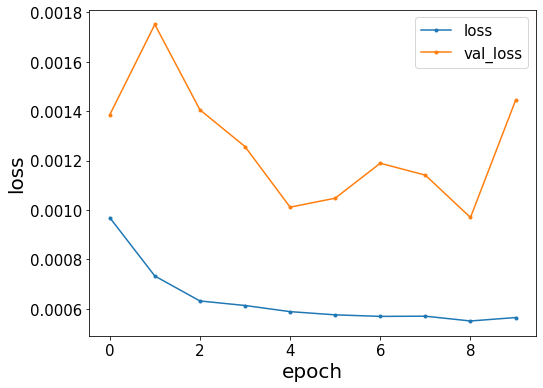

In [43]:
import matplotlib.pyplot as plt

def plot_history(hist, loss_names=['loss', 'val_loss']):
    # Simple function to plot training history.
    plt.style.use('ggpot2')
    plt.figure(figsize=(8, 6))
    for loss_name in loss_names:
        plt.plot(hist.epoch, hist.history[loss_name], '.-', label=loss_name)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()


plot_history(hist)

In [32]:
vxm_model.save_weights('../models/vxm_drosophila_2d.h5')

## Validation

In [33]:
from modules.utils import get_strategy
strategy = get_strategy('GPU')

[2021-11-26 13:31:59,289] I T140302596278080 utils.py:600: Num Physical GPUs Available: 1
[2021-11-26 13:31:59,289] I T140302596278080 utils.py:601: Num Logical  GPUs Available: 1
[2021-11-26 13:31:59,290] I T140302596278080 utils.py:602: Num TPUs Available: 0
[2021-11-26 13:31:59,290] W T140302596278080 utils.py:612: GPU device "PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')" is already initialized.


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


[2021-11-26 13:31:59,292] I T140302596278080 utils.py:628: using GPU "MirroredStrategy" strategy.


In [34]:
# retrieve dataset shape
PATH = orig_examples[0]
in_shape = tiff.imread(PATH, key=0).shape

In [35]:
# configure unet features 
nb_features = [
    [32, 32, 32, 64],         # encoder features
    [64, 32, 32, 16, 16, 16]  # decoder features
]

# build model using VxmDense
with strategy.scope():
    vxm_model = vxm.networks.VxmDense(in_shape, nb_features, int_steps=0)

In [36]:
vxm_model.load_weights('../models/vxm_drosophila_2d.h5')

validation video,

In [41]:
x_val = tiff.imread(orig_examples[0], key=range(200))
x_val, (x_val_low, x_val_hig) = preprocessing(x_val)

# let's get some data
val_generator = vxm_data_generator(x_val, batch_size=16, training=False)

In [42]:
import time
val_pred = []
t1 = time.perf_counter()
for (val_input, _) in val_generator:
    val_pred += [vxm_model.predict(val_input, verbose=2)]
t2 = time.perf_counter()
print(f'Registered in {t2-t1:.2f}s | {x_val.shape[0]/(t2-t1) : .0f} frames / s')
val_pred = [
    np.concatenate([a[0] for a in val_pred], axis=0),
    np.concatenate([a[1] for a in val_pred], axis=0)
]

1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
Registered in 1.70s |  118 frames / s


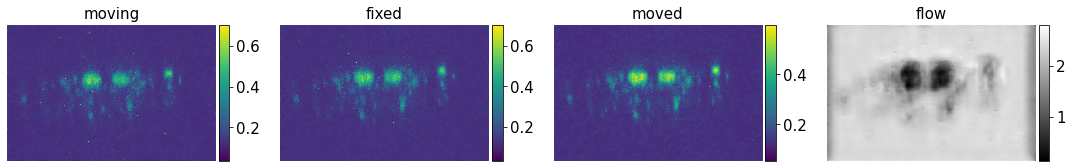

In [43]:
# visualize
images = [img[0, :, :, 0] for img in val_input + val_pred] 
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['viridis', 'viridis', 'viridis', 'gray'], do_colorbars=True);

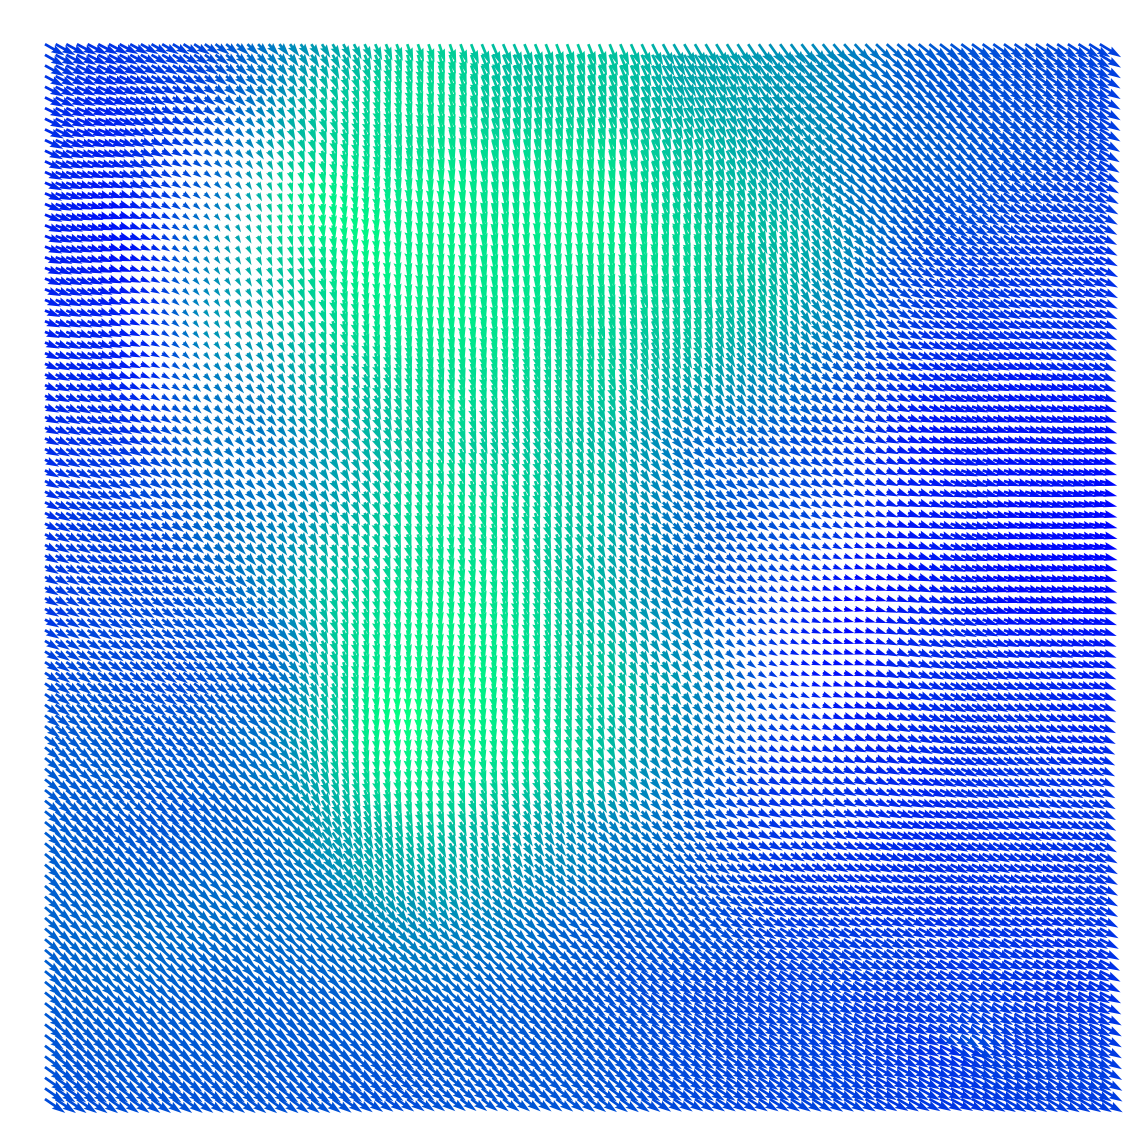

In [44]:
ne.plot.flow([val_pred[1][0, 150:250, 250:350, :].squeeze()], width=16);

In [45]:
make_video('out', frame_gen(val_pred[0]))
Video('out.mov')

calculated std


200it [00:00, 299.07it/s]


converting video..
Done (1.32s)


In [45]:
make_video('out', frame_gen(val_pred[0]))
Video('out.mov')

calculated std


200it [00:00, 299.07it/s]


converting video..
Done (1.32s)


# Visualize trained model

# Validation results

In [5]:
path = "../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.tif"
x_val = tiff.imread(path)
make_video('out', frame_gen(x_val))
Video('out.mov')

calculated std


4100it [00:15, 260.56it/s]
ffmpeg: /home/adrian/miniconda3/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


converting video..
Done (24.30s)


In [13]:
Video('../bin/train-voxelmorph.out/validation-video.mov')

# Scoring

We follow the same scoring procedure as in Voxelmorph.

MSE,

In [10]:
import voxelmorph as vxm
from stabilize2p.utils import vxm_data_generator

In [12]:
path = pystackreg_examples[4]
img_gen = vxm_data_generator(path, batch_size=8, training=False, affine_tranform=True)
MSE_loss = vxm.losses.MSE().loss
mse = []
t1 = time.perf_counter()
for (ins, _) in img_gen:
    moved, fixed = ins
    mse += [MSE_loss(moved, fixed).numpy()]
mse = np.mean(mse)
t2 = time.perf_counter()

print(f'pysreg MSE: {mse} | {t2-t1:.3g}s')

[2021-12-02 10:00:25,660] W T140451127632704 utils.py:156: pixel histogram is uni-modal, estimated threshold may not be accurate.
[2021-12-02 10:00:26,047] W T140451127632704 utils.py:156: pixel histogram is uni-modal, estimated threshold may not be accurate.
[2021-12-02 10:00:27,761] W T140451127632704 utils.py:156: pixel histogram is uni-modal, estimated threshold may not be accurate.
[2021-12-02 10:00:34,549] W T140451127632704 utils.py:156: pixel histogram is uni-modal, estimated threshold may not be accurate.
[2021-12-02 10:00:37,395] W T140451127632704 utils.py:156: pixel histogram is uni-modal, estimated threshold may not be accurate.
[2021-12-02 10:00:45,690] W T140451127632704 utils.py:156: pixel histogram is uni-modal, estimated threshold may not be accurate.
[2021-12-02 10:00:45,951] W T140451127632704 utils.py:156: pixel histogram is uni-modal, estimated threshold may not be accurate.
[2021-12-02 10:00:46,340] W T140451127632704 utils.py:156: pixel histogram is uni-modal, e

pysreg MSE: 0.0022628220799935676 | 33.5s


In [8]:
import voxelmorph as vxm
from stabilize2p.utils import vxm_data_generator

path = ofco_examples[4]
img_gen = vxm_data_generator(path, batch_size=8, training=False)
MSE_loss = vxm.losses.MSE().loss
mse = []
for (ins, _) in img_gen:
    moved, fixed = ins
    mse += [MSE_loss(moved, fixed).numpy()]
mse = np.mean(mse)

print(f'ofco MSE: {mse}')

ofco MSE: 0.0006432684353060334


In [7]:
from stabilize2p.utils import get_centers


def plot_centers(image):    
    radius = 0.01 * min(*image.shape[1:])

    # calculate centers
    centers = get_centers(image)

    m_centers = centers.mean(axis=0)
    s_centers = centers.std(axis=0)
    print(f'x: {m_centers[0]:.2f} + {s_centers[0]:.2f}')
    print(f'y: {m_centers[1]:.2f} + {s_centers[1]:.2f}')
    
    plt.figure(figsize=(4, 4))
    ax = plt.subplot(111)

    circ = plt.Circle(m_centers, radius, color='r', alpha=.25)
    ax.add_patch(circ)

    ax.scatter(centers[:, 0], centers[:, 1], s=1.5, alpha=0.5)
    ax.plot(m_centers[0], m_centers[1], 'ko')
    
    lx, ly = ax.get_xlim()[0], ax.get_ylim()[0]
    dx = ax.get_xlim()[1] - lx
    dy = ax.get_ylim()[1] - ly
    dmax = max(dx, dy)
    ax.set_xlim(lx, lx + dmax); ax.set_ylim(ly + dmax, ly);
    
    plt.title(r'Centers of mass')
    plt.show()

x: 367.87 + 1.23
y: 237.07 + 1.03


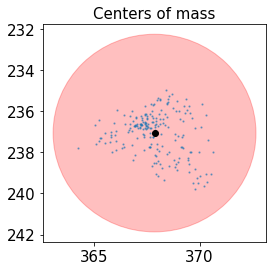

356 frames/s | 0.00281 s/frame
x: 367.89 + 0.15
y: 237.11 + 0.10


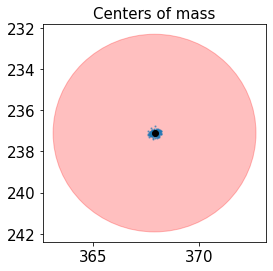

calculated std


200it [00:00, 252.81it/s]
ffmpeg: /home/adrian/miniconda3/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


converting video..
Done (1.38s)


In [11]:
from stabilize2p.utils import estimate_background_threshold
from stabilize2p.register import com_transform, pysreg_transform

path = "../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/denoised_red.tif"
x_val = tiff.imread(path, key=range(200, 400))

plot_centers(x_val)

t1 = time.perf_counter()
com_transform(x_val, inplace=True, downsample=2)  # 356 frames/s | 0.00281 s/frame
# x_val = pysreg_transform(x_val)                 # 7 frames/s | 0.145 s/frame
t2 = time.perf_counter()
print(f'{x_val.shape[0]/(t2-t1):.0f} frames/s | {(t2-t1)/x_val.shape[0]:.3g} s/frame')

plot_centers(x_val)

make_video('out', frame_gen(x_val))
Video('out.mov')